# Simple autoencoder for Tabula Sapiens dataset only
Apapted from the sample code provided along with the paper

Use mse loss

With Weights and Bias watch


In [1]:
import wandb
wandb.login()

/home/niklas/Documents/TUM/5-WS2324/SysGen/Project/repo/notebooks/venv/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/home/niklas/Documents/TUM/5-WS2324/SysGen/Project/repo/notebooks/venv/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.


True

In [2]:
import torch
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.metrics import r2_score
import torch.nn as nn
import numpy as np
import pandas as pd
import scanpy as sc
from torch.distributions.beta import Beta
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

from dataset import TS_Compressed_Dataset

In [3]:
config = dict(
    EPOCHS = 20,
    BATCH_SIZE = 1e3,
    LEARNING_RATE = 1e-3,
    NUM_LAYERS = 4,
)

In [4]:
#load the dataframe that contains one to one corresponding of gene id and gene index
gene_index = pd.read_csv("gene_index.csv")
path = "TabulaSapiens_CO_compressed.h5ad"

dataset = TS_Compressed_Dataset(gene_index, path)

In [4]:
device = torch.device("cpu")

gene_list = gene_index.gene_id.to_list()
n_genes = len(gene_list)  #the number of total genes 
emb_dim = 128  #the gene embedding dimension

NUM_LAYERS = 4  #the number decoder layers

assay_prior_log_sigma = float(0)

LEARNING_RATE = 0.001

EPOCHS = 9
BATCH_SIZE = int(1e5)

In [5]:
class GeneEmbedding(torch.nn.Module):
    def __init__(self, n_genes, emb_dim, gene_list, emb_init=None):
        super(GeneEmbedding, self).__init__()

        self.n_genes = n_genes
        self.emb_dim = emb_dim
        self.genes = gene_list

        """
        model the gene embedding as gaussian distributions computed from the mean embeddings and sd embeddings
        """
        if emb_init is not None:
            self.emb_mu = nn.Embedding.from_pretrained(emb_init, freeze=False)
        else:
            # init as [0, 1], as the dirichlet prior is in [0, 1]
            self.emb_mu = nn.Embedding.from_pretrained(
                torch.rand((n_genes, emb_dim)), freeze=False
            )

        self.emb_log_sigma = nn.Embedding.from_pretrained(
            torch.full((n_genes, emb_dim), np.log(0.5)), freeze=False
        )

    def get_emb_table(self):
        emb_df = pd.DataFrame(self.emb_mu.weight.detach().cpu(),
                              index=self.genes,
                              columns=[f'FACT_EMB_{i}' for i in range(self.emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df

    def get_log_sigma_table(self):
        emb_df = pd.DataFrame(self.emb_log_sigma.weight.detach().cpu(),
                              index=self.genes,
                              columns=[f'FACT_EMB_{i}' for i in range(self.emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df

    def get_shape(self):
        return (self.n_genes, self.emb_dim)



In [6]:
#initialize the gene embedding
gene_emb = GeneEmbedding(n_genes,
                         emb_dim,
                         gene_list,
                         emb_init=torch.rand(n_genes, emb_dim) - 0.5,
                         )

In [7]:
class VAE(nn.Module):
    def __init__(self, gene_emb, n_samples, sample_emb_dim, NUM_LAYERS, sample_emb_init = None):
        super().__init__()
        #initialize the gene embedding
        self.gene_emb = gene_emb
        #create sample embedding
        if sample_emb_init is not None:
            self.sample_emb = nn.Embedding.from_pretrained(sample_emb_init, freeze=False)
        else:
            self.sample_emb = nn.Embedding(n_samples, sample_emb_dim)

        joint_emb_dim = sample_emb_dim + self.gene_emb.gene_emb_dim

        #the decoder
        self.model = nn.Sequential()
        for i in range(NUM_LAYERS - 1):
            self.model.add_module(f"layer_{i}", nn.Linear(joint_emb_dim, joint_emb_dim))
            self.model.add_module(f"relu_{i}", nn.ReLU())
        self.model.add_module(f"layer_{NUM_LAYERS - 1}", nn.Linear(joint_emb_dim, 1))


    def reparameterization(self, mean, sd):
        epsilon = torch.randn_like(sd)    # sampling epsilon
        z = mean + sd * epsilon           # reparameterization trick
        return z


    def get_emb(self, idx):
        emb_mu = self.gene_emb.emb_mu.weight
        emb_sigma = self.gene_emb.emb_log_sigma.weight.exp()
        emb_z = self.reparameterization(emb_mu[idx, :], emb_sigma[idx, :])
        return emb_z


    def forward(self, gene_index, sample_index):
        #get the gene embeddings and sample embeddings from indices
        gene_emb_batch = self.get_emb(gene_index)
        sample_emb_batch = self.sample_emb(sample_index)
        joint_emb = torch.cat((gene_emb_batch, sample_emb_batch), dim = 1)

        #use the joint embeddings to predict the score
        pred = self.model(joint_emb)
        return pred.squeeze()



,FACT_EMB_0,FACT_EMB_1,FACT_EMB_2,FACT_EMB_3,FACT_EMB_4,FACT_EMB_5,FACT_EMB_6,FACT_EMB_7,FACT_EMB_8,FACT_EMB_9,...,FACT_EMB_118,FACT_EMB_119,FACT_EMB_120,FACT_EMB_121,FACT_EMB_122,FACT_EMB_123,FACT_EMB_124,FACT_EMB_125,FACT_EMB_126,FACT_EMB_127
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.106010,-0.461595,0.052587,0.373025,0.144046,0.180251,0.340764,0.185999,0.409812,-0.156807,...,-0.460837,-0.066769,0.137612,0.458751,0.236506,0.365504,-0.214861,0.176975,-0.072642,0.401280
ENSG00000148584,-0.290709,0.391785,-0.395638,-0.353576,-0.307094,-0.465218,-0.344927,0.091459,-0.374749,0.199789,...,-0.073596,0.256913,-0.366361,-0.250737,-0.223580,-0.352380,-0.394107,0.092721,-0.399471,0.289553
ENSG00000175899,0.242142,-0.449453,0.157252,0.106424,0.398344,-0.070693,0.465176,-0.439344,-0.015031,-0.157172,...,0.433542,-0.142104,-0.297896,-0.267788,-0.014850,-0.320458,0.419811,0.086315,-0.131879,0.190226
ENSG00000166535,0.090354,-0.116053,-0.194001,-0.311927,-0.085125,0.097920,0.256587,0.275354,0.382139,-0.126973,...,-0.177966,0.409191,-0.289672,0.060570,-0.248142,-0.117346,0.493707,0.172840,-0.390717,0.238202
ENSG00000184389,-0.396374,0.194550,0.477474,-0.388095,0.313079,-0.118485,-0.248787,0.346253,0.084341,-0.160892,...,-0.196248,-0.049565,-0.217718,0.309336,0.037185,0.039028,0.220830,0.457047,0.209597,0.192745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000203995,-0.478342,-0.383682,0.456813,0.457497,-0.185068,0.288327,-0.398313,0.276065,-0.458201,-0.036350,...,-0.176912,0.465491,-0.237820,-0.097224,-0.425809,0.100537,0.271502,0.135968,-0.042828,-0.195250
ENSG00000162378,0.081361,-0.076860,0.153846,0.348684,0.393668,-0.174394,-0.101181,-0.228229,0.271773,-0.046598,...,-0.208113,0.305136,-0.084824,0.215689,0.218954,0.076550,0.096553,0.118520,0.369082,-0.163983
ENSG00000159840,0.076599,0.064329,0.413553,0.155864,0.484874,0.292472,0.199863,-0.144120,-0.085168,0.036192,...,-0.280488,0.295061,0.253246,-0.173650,0.483735,-0.300305,0.296135,0.416069,-0.005561,-0.054826


In [8]:
class AssayModel(torch.nn.Module):
    def __init__(self, gene_emb, sigma_init=np.log(0.5)):
        super().__init__()

        self.gene_emb = gene_emb

        self.assay_log_sigma = nn.Embedding.from_pretrained(
            torch.full(gene_emb.get_shape(), sigma_init), freeze=False
        )

        self.pass_assay_log_sigma = False

    def reparameterization(self, mean, sd):
        epsilon = torch.randn_like(sd)  # sampling epsilon        
        z = mean + sd * epsilon  # reparameterization trick
        return z

    # get mean log_sigma of the current assay without gradient. 
    def get_assay_log_sigma_mean(self, idx):
        with torch.no_grad():
            assay_log_sigma_mean = self.assay_log_sigma.weight.mean(axis=1, keepdim=True)
            assay_log_sigma_mean = assay_log_sigma_mean[idx, :]
        return assay_log_sigma_mean

    def get_emb(self, idx):
        emb_mu = self.gene_emb.emb_mu.weight
        emb_sigma = self.gene_emb.emb_log_sigma.weight.exp()
        assay_sigma = self.assay_log_sigma.weight.exp()

        # replace the sampling twice by sampling only once using mu = mu_1 + mu_2 and sig^2 = sig_1^2 + sig_2^2
        sigma = torch.sqrt(emb_sigma.pow(2) + assay_sigma.pow(2))
        z_emb_assay = self.reparameterization(emb_mu[idx, :], sigma[idx, :])

        # add assay log sigma to embedding without gradient.
        if self.pass_assay_log_sigma is True:
            assay_log_sigma_mean = self.get_assay_log_sigma_mean(idx)
            z_emb_assay = torch.cat((z_emb_assay, assay_log_sigma_mean), dim=1)
        return z_emb_assay

    def get_assay_log_sigma_table(self):
        emb_df = pd.DataFrame(self.assay_log_sigma.weight.detach().cpu(),
                              index=self.gene_emb.genes,
                              columns=[f'FACT_EMB_{i}' for i in range(self.gene_emb.emb_dim)]
                              )
        emb_df.index.name = 'gene_id'
        return emb_df

In [9]:
class TabluarDataModel(AssayModel):
    def __init__(self, gene_emb, n_samples, emb_dim, sigma_init, pass_assay_log_sigma=False, emb_init=None):
        super().__init__(gene_emb, sigma_init)

        self.pass_assay_log_sigma = pass_assay_log_sigma

        #create sample embedding
        if emb_init is not None:
            self.sample_emb = nn.Embedding.from_pretrained(emb_init, freeze=False)
            #self.register_parameter("sample_emb",nn.Embedding.from_pretrained(emb_init, freeze=False))
        else:
            self.sample_emb = nn.Embedding(n_samples, emb_dim)

        joint_emb_dim = emb_dim + self.gene_emb.emb_dim
        var_model_dim = self.gene_emb.emb_dim

        if pass_assay_log_sigma is True:
            joint_emb_dim += 1
            var_model_dim += 1

        self.model = nn.Sequential()

        for i in range(NUM_LAYERS - 1):
            self.model.add_module(f"layer_{i}", nn.Linear(joint_emb_dim, joint_emb_dim))
            self.model.add_module(f"relu_{i}", nn.ReLU())

        self.model.add_module(f"layer_{NUM_LAYERS - 1}", nn.Linear(joint_emb_dim, 1))

        self.var_model = nn.Sequential()

        for i in range(NUM_LAYERS - 1):
            self.var_model.add_module(f"layer_{i}", nn.Linear(var_model_dim, var_model_dim))
            self.var_model.add_module(f"relu_{i}", nn.ReLU())

        self.var_model.add_module(f"layer_{NUM_LAYERS - 1}", nn.Linear(var_model_dim, 1))
        # Init bias of last layer with small variance.
        nn.init.constant_(self.var_model[-1].bias, -2)

    #@torch.jit.script
    def forward(self, gene_index, sample_index):

        #get the gene embeddings and sample embeddings from indices
        gene_emb_batch = self.get_emb(gene_index)
        sample_emb_batch = self.sample_emb(sample_index)

        joint_emb = torch.cat((gene_emb_batch, sample_emb_batch), dim=1)

        #use the joint embeddings to predict the score
        pred = self.model(joint_emb)
        #use the gene embeddings alone to predict the score???
        log_var = self.var_model(gene_emb_batch)
        # clip to avoid exp of log var to become inf or 0.
        log_var = log_var.clip(min=-40, max=40)

        return pred.squeeze(), log_var.squeeze()





In [10]:
class BaseLoss(nn.Module):
    def __init__(self, assay_prior_log_sigma):
        super(BaseLoss, self).__init__()

        self.assay_ls = torch.as_tensor(np.float32(assay_prior_log_sigma), device=device)
        self.emb_log_sigma_prior = torch.as_tensor(0., device=device)

    def compute_kl(self, model):
        loss_KLD_emb = kl_divergence(Normal(model.gene_emb.emb_mu.weight, model.gene_emb.emb_log_sigma.weight.exp()),
                                     Normal(0, self.emb_log_sigma_prior.exp())
                                     ).mean()
        loss_KLD_assay = kl_divergence(Normal(0, model.assay_log_sigma.weight.exp()),
                                       Normal(0, self.assay_ls.exp())
                                       ).mean()
        return loss_KLD_assay + loss_KLD_emb


class MatLoss(BaseLoss):
    def __init__(self, assay_prior_log_sigma):
        super(MatLoss, self).__init__(assay_prior_log_sigma)

        self.mse_loss_mean = nn.MSELoss(reduction="mean")
        self.gnll = nn.GaussianNLLLoss(full=True, reduction='mean')

    def forward(self, pred_mu, pred_log_var, target, model):
        loss_NLL = self.gnll(pred_mu, target, torch.exp(pred_log_var))
        kl_term = self.compute_kl(model)

        return loss_NLL + kl_term, self.mse_loss_mean(pred_mu, target), loss_NLL  #, loss_KLD_emb + loss_KLD_assay


In [11]:
#initilize the model
model = TabluarDataModel(gene_emb,
                         n_samples=dataset.dataset["sample_idx"].unique().shape[0],
                         emb_dim=128,
                         sigma_init=assay_prior_log_sigma,
                         emb_init=torch.from_numpy(dataset.compute_sample_init_pca().astype('float32')),
                         )

loss = MatLoss(assay_prior_log_sigma)

opt = torch.optim.Adam(model.parameters(),
                       lr=LEARNING_RATE,
                       )

In [12]:
dataset.test_table

sample_idx,gene_id,score,gene_idx
i64,str,f32,i64
103,"""ENSG0000009928…",-0.024914,9382
65,"""ENSG0000018943…",-0.027687,13792
167,"""ENSG0000013240…",-0.027114,16711
11,"""ENSG0000011709…",-0.027691,15186
96,"""ENSG0000013569…",0.060683,10038
91,"""ENSG0000017077…",-0.024835,6759
156,"""ENSG0000016667…",-0.027691,18041
87,"""ENSG0000017140…",-0.027691,12188
24,"""ENSG0000018686…",-0.027691,12242


In [13]:
torch.from_numpy(np.array(dataset.test_table["gene_idx"]))

tensor([ 9382, 13792, 16711,  ...,  5428,  7792, 18109])

In [16]:
def train_epoch(model, opt, loss_func, dataset):
    for g_idx, s_idx, target in dataset.get_batches(BATCH_SIZE, 'train'):
        model.to(device)

        opt.zero_grad()
        mu, log_var = model(g_idx.to(device, non_blocking=True), s_idx.to(device, non_blocking=True))
        target = target.to(device, non_blocking=True)
        elbo, mse, nll = loss_func(mu, log_var, target, model)

        # sum losses, temporarily use the elbo
        loss = elbo
        loss.backward()
        opt.step()

    opt.zero_grad(set_to_none=True)
    # torch.mps.empty_cache()

    #compute the r2score on the test data
    with torch.no_grad():
        test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"]))
        test_sample_idx = torch.from_numpy(np.array(dataset.test_table["sample_idx"]))
        test_target = torch.from_numpy(np.array(dataset.test_table["score"]))
        mu, log_var = model(test_gene_idx.to(device, non_blocking=True), test_sample_idx.to(device, non_blocking=True))
        val_pred = mu.detach().cpu().numpy()
        val_target = test_target.detach().cpu().numpy()
    """
    val_pred = []
    val_target = []
    with torch.no_grad():
             for g_idx, s_idx, target in dataset.get_batches(BATCH_SIZE, 'test'):
                    mu, log_var = model(g_idx.to(device, non_blocking=True), s_idx.to(device, non_blocking=True))
                    target = target.to(device, non_blocking=True)
                    elbo, mse, nll = loss_func(mu, 
                                               log_var, 
                                               target,
                                               model
                                               )

                    val_pred.append(mu.detach().cpu().numpy())
                    val_target.append(target.detach().cpu().numpy())
                

    ## compute r2
    val_pred = np.concatenate(val_pred)
    val_target = np.concatenate(val_target)
    """
    r2 = r2_score(val_target, val_pred)
    return r2








In [17]:
r2 = []
for i in range(EPOCHS):
    print(i)
    r2.append(train_epoch(model, opt, loss, dataset))

r2score:  0.1528988648396311


In [18]:
r2

[0.0024774620240672895,
 0.0018061029536360351,
 0.0024515588413861478,
 0.0021453899649245267,
 0.0024973022102946496,
 0.002463137248999603,
 0.0021021136575449795,
 0.001998808288710796,
 0.0014751710484437464]

In [19]:
with torch.no_grad():
    test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"]))
    test_sample_idx = torch.from_numpy(np.array(dataset.test_table["sample_idx"]))
    test_target = torch.from_numpy(np.array(dataset.test_table["score"]))
    mu, log_var = model(test_gene_idx.to(device, non_blocking=True), test_sample_idx.to(device, non_blocking=True))
    val_pred = mu.detach().cpu().numpy()
    val_target = test_target.detach().cpu().numpy()

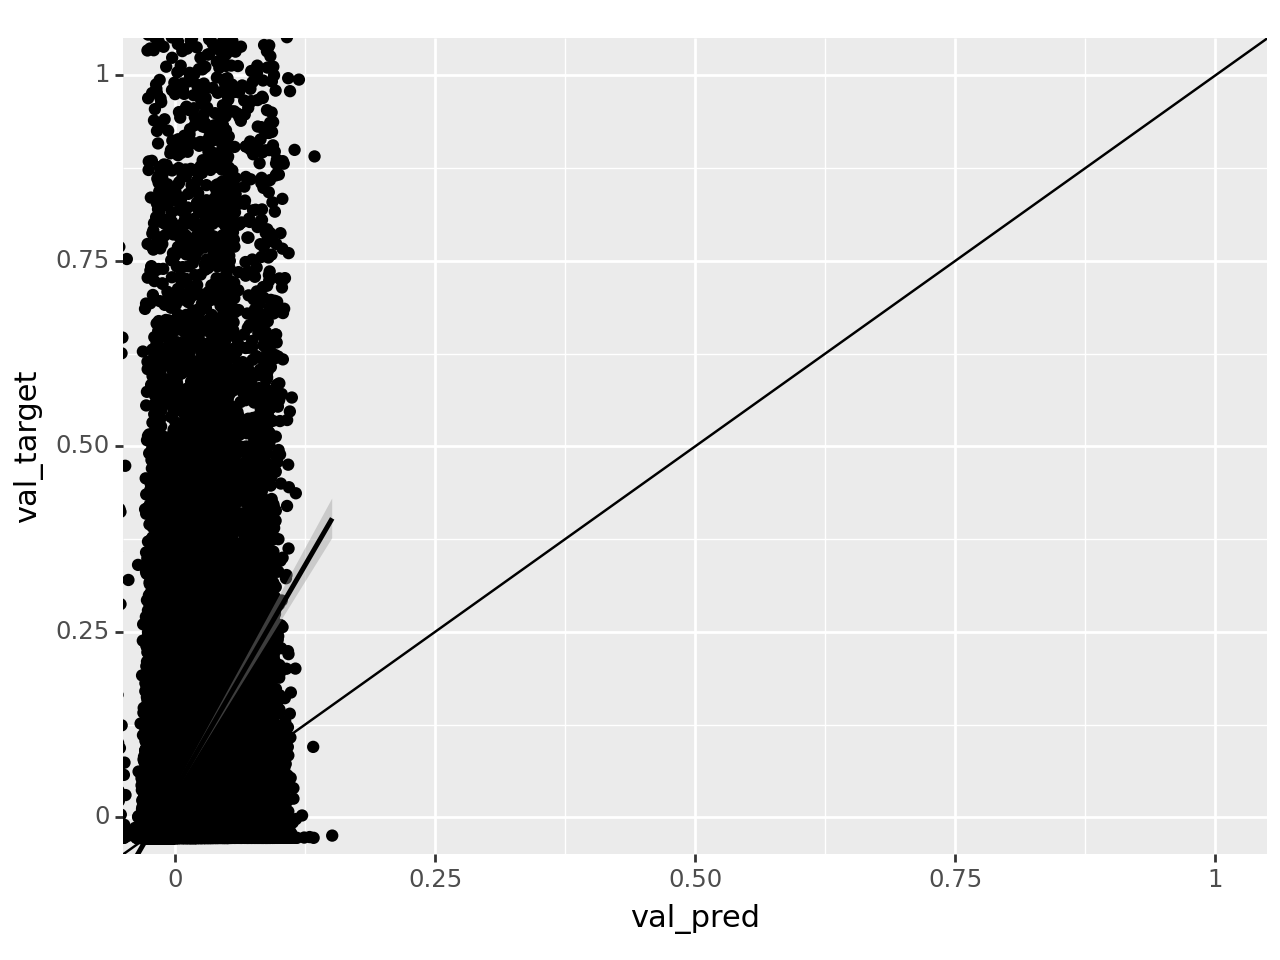

<Figure Size: (640 x 480)>

In [20]:
with torch.no_grad():
        test_gene_idx = torch.from_numpy(np.array(dataset.test_table["gene_idx"]))
        test_sample_idx = torch.from_numpy(np.array(dataset.test_table["sample_idx"]))
        test_target = torch.from_numpy(np.array(dataset.test_table["score"]))
        mu = model(test_gene_idx.to(device, non_blocking=True), test_sample_idx.to(device, non_blocking=True))
        val_pred = mu.detach().cpu().numpy()
        val_target = test_target.detach().cpu().numpy()
result = pd.DataFrame({
    "val_pred": val_pred,
    "val_target": val_target})
plot = ggplot(result)
plot += geom_point(aes("val_pred", "val_target"))
plot += coord_cartesian(ylim=(0, 1), xlim=(0, 1))
plot += geom_smooth(aes("val_pred", "val_target"))
plot += geom_abline(intercept=0, slope=1)
plot

In [21]:
emb_table = gene_emb.get_emb_table()
emb_table

,FACT_EMB_0,FACT_EMB_1,FACT_EMB_2,FACT_EMB_3,FACT_EMB_4,FACT_EMB_5,FACT_EMB_6,FACT_EMB_7,FACT_EMB_8,FACT_EMB_9,...,FACT_EMB_118,FACT_EMB_119,FACT_EMB_120,FACT_EMB_121,FACT_EMB_122,FACT_EMB_123,FACT_EMB_124,FACT_EMB_125,FACT_EMB_126,FACT_EMB_127
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.397898,-0.619606,0.197080,0.206075,0.487327,-0.130210,0.694295,0.066933,-0.002644,0.019016,...,-0.586537,-0.189327,-0.281588,0.794226,0.450134,-0.056704,0.189903,0.090775,-0.312061,0.013795
ENSG00000148584,0.019631,0.105285,-0.164675,-0.366149,0.041693,-0.605392,0.039391,-0.081647,-0.680132,0.417165,...,-0.303413,0.135788,-0.749402,0.081660,0.071958,-0.663785,0.006457,0.008557,-0.572154,-0.091617
ENSG00000175899,0.206388,-0.434583,0.135077,0.136972,0.349690,-0.053918,0.380534,-0.405700,0.025218,-0.166301,...,0.444234,-0.126186,-0.215977,-0.316875,-0.029652,-0.274389,0.368234,0.035494,-0.097415,0.203788
ENSG00000166535,0.361388,-0.309084,0.044041,-0.345444,0.249813,-0.171147,0.622800,0.097036,-0.022604,0.158736,...,-0.357637,0.251788,-0.656097,0.422899,0.086865,-0.457098,0.814789,0.108453,-0.549387,-0.137657
ENSG00000184389,-0.084553,-0.079659,0.521774,-0.344599,0.608893,-0.269933,0.134993,0.208777,-0.292158,0.041449,...,-0.331455,-0.152695,-0.602804,0.640094,0.303997,-0.311243,0.588258,0.301015,-0.071225,-0.188245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000203995,-0.192088,-0.527726,0.564879,0.334749,0.164973,-0.011938,-0.005079,0.163140,-0.776939,0.165401,...,-0.316673,0.324286,-0.619148,0.269568,-0.051767,-0.273430,0.619877,0.170769,-0.324416,-0.575503
ENSG00000162378,0.389417,-0.302356,0.226134,0.231177,0.633049,-0.378878,0.270924,-0.321942,-0.136347,0.192838,...,-0.366426,0.143965,-0.476664,0.549909,0.454654,-0.310580,0.454901,0.000682,0.061252,-0.540969
ENSG00000159840,0.343140,-0.140446,0.471138,0.054814,0.631070,0.075271,0.560676,-0.242739,-0.427519,0.212996,...,-0.346511,0.169067,-0.148972,0.167146,0.636596,-0.570514,0.616379,0.264107,-0.240854,-0.424334


In [23]:
emb_table.to_csv('../../data/TabulaSapiens_d128.tsv', sep='\t')

## remaining questions
- which loss function to use
- should the domain adaptation model be included (when there are more than one assays)
- how to set the hypterparameters
- should we use the compressed data after all since compressed data loses information